# Feature Engineering Notebook

This notebook loads the enriched heartbeat metadata, creates reproducible stratified splits, extracts lightweight acoustic features, and trains a simple baseline classifier. Keep it fast, transparent, and easily swappable for deeper models later.

In [1]:
from __future__ import annotations
from pathlib import Path
import pandas as pd
import numpy as np
import librosa as lr
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
import json, time
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_context('talk')

DATA_ROOT = Path(r'../data')
META_PATH = DATA_ROOT / 'heartbeat_metadata_enriched.csv'
SPLIT_DIR = Path(DATA_ROOT / 'splits'); SPLIT_DIR.mkdir(exist_ok=True)
FEATURE_DIR = Path(DATA_ROOT / 'features'); FEATURE_DIR.mkdir(exist_ok=True)

RANDOM_SEED = 42
TEST_SIZE = 0.15
VAL_SIZE = 0.15  # of remaining after test split
TARGET_SR = None  # resample for uniformity (None keeps native)
N_MELS = 64
HOP_LENGTH = 256
MAX_DEBUG_FILES = None  # set small int (e.g., 50) to speed up iteration

META_PATH

WindowsPath('../data/heartbeat_metadata_enriched.csv')

In [2]:
# Logging configuration (run once)
import logging, sys
LOG_LEVEL = logging.INFO  # change to logging.DEBUG for more verbosity
logger = logging.getLogger('feature_engineering')
logger.setLevel(LOG_LEVEL)
if not logger.handlers:
    ch = logging.StreamHandler(sys.stdout)
    ch.setFormatter(logging.Formatter('[%(asctime)s] %(levelname)s %(message)s'))
    logger.addHandler(ch)
    # Optional: also log to file in FEATURE_DIR
    fh = logging.FileHandler(FEATURE_DIR / 'feature_extraction.log', mode='w')
    fh.setFormatter(logging.Formatter('%(asctime)s %(levelname)s %(message)s'))
    logger.addHandler(fh)
logger.info('Logger initialized (level=%s)', logging.getLevelName(LOG_LEVEL))

[2025-09-06 18:23:56,163] INFO Logger initialized (level=INFO)


## 1. Load Enriched Metadata
Load the unified metadata produced in the EDA stage. Assert required columns are present.

In [3]:
meta = pd.read_csv(META_PATH)
expected = {'label','path_fname','duration_sec','sr'}
missing = expected - set(meta.columns)
assert not missing, f'Missing columns: {missing}'
print('Rows:', len(meta))
print(meta['label'].value_counts())
meta.head()

Rows: 105
label
artifact    40
murmur      34
normal      31
Name: count, dtype: int64


,dataset,fname,label,sublabel,__meta_source,path_fname,duration_sec,sr
0,a,set_a/artifact__201012172012.wav,artifact,NaN,set_a.csv,C:\Users\Michi\heatbeat-sounds\data\set_a\arti...,9.0,44100.0
1,a,set_a/artifact__201105040918.wav,artifact,NaN,set_a.csv,C:\Users\Michi\heatbeat-sounds\data\set_a\arti...,9.0,44100.0
2,a,set_a/artifact__201105041959.wav,artifact,NaN,set_a.csv,C:\Users\Michi\heatbeat-sounds\data\set_a\arti...,9.0,44100.0
3,a,set_a/artifact__201105051017.wav,artifact,NaN,set_a.csv,C:\Users\Michi\heatbeat-sounds\data\set_a\arti...,9.0,44100.0
4,a,set_a/artifact__201105060108.wav,artifact,NaN,set_a.csv,C:\Users\Michi\heatbeat-sounds\data\set_a\arti...,9.0,44100.0


## 2. Revamped Pipeline Overview (Train/Test + 5-Fold CV)
We rebuild feature engineering with a clearer structure:

Steps:
1. Train/Test Split (70/30 stratified) – no separate validation; we use 5-fold CV inside train.
2. Feature Extraction per file combining:
   - Raw signal statistics (energy, zero-crossing, spectral descriptors, amplitude shape, autocorrelation periodicity)
   - Aggregated log-mel statistics (mean/std/quantiles/dynamic range)
3. Tabular feature matrix assembly (optionally subsample for speed).
4. Feature Selection / Dimensionality Reduction strategies compared via 5-fold CV:
   - Baseline (no selection)
   - MI + Correlation pruning
   - PCA (unsupervised)
   - Embedded L1 Logistic Regression
   - (Optional) RFECV wrapper (disabled by default for speed)
5. Model comparison (macro F1 & accuracy).
6. Final fit on full train set with best strategy; evaluation on holdout test.
7. Visual diagnostics (importance bars, pairwise plots, PCA scatter, correlation heatmap).

All helper functions below include docstrings. Configure behavior via the constants cell that follows.

In [4]:
from dataclasses import dataclass
from typing import List, Dict, Tuple, Callable, Optional
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import scipy.stats as stats
import logging
from time import time

# Reuse earlier imports (librosa, numpy, pandas, etc.) already loaded.
logger = logging.getLogger("feature_engineering")

@dataclass
class FeatureConfig:
    """Configuration controlling feature extraction.

    Attributes
    ----------
    target_sr : Optional[int]
        Desired sample rate for loading audio (None keeps native).
    n_mels : int
        Number of mel bands for log-mel aggregation.
    hop_length : int
        Hop length used for STFT/mel computations.
    use_mel : bool
        Whether to compute aggregated mel statistics.
    use_raw_stats : bool
        Whether to compute raw waveform & spectral statistics (amplitude + spectral descriptors).
    use_periodicity : bool
        Whether to compute autocorrelation-based periodicity features (can be expensive on long clips).
    max_files : Optional[int]
        If set, limits number of audio files processed (debug speed-up).
    log_interval : int
        How many files between progress logs.
    tolerate_errors : bool
        If True, continue after logging an exception for a file.
    """
    target_sr: Optional[int] = TARGET_SR
    n_mels: int = N_MELS
    hop_length: int = HOP_LENGTH
    use_mel: bool = True
    use_raw_stats: bool = True
    use_periodicity: bool = True
    max_files: Optional[int] = None
    log_interval: int = 25
    tolerate_errors: bool = True

FEAT_CFG = FeatureConfig()

RAW_PREFIX = "raw_"
MEL_PREFIX = "melagg_"


def train_test_split_stratified(df: pd.DataFrame, test_size: float = 0.30, seed: int = RANDOM_SEED) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Perform a stratified train/test split."""
    return train_test_split(df, test_size=test_size, stratify=df['label'], random_state=seed)


def waveform_basic_stats(y: np.ndarray) -> Dict[str, float]:
    """Compute basic amplitude-domain statistics: mean/std/skew/kurtosis, RMS, peak, crest factor, zero-crossing rate."""
    if y.size == 0:
        return {k: np.nan for k in ["mean","std","skew","kurt","rms","peak","crest","zcr"]}
    mean = float(y.mean())
    std = float(y.std())
    skew = float(stats.skew(y)) if std > 0 else 0.0
    kurt = float(stats.kurtosis(y)) if std > 0 else 0.0
    rms = float(np.sqrt(np.mean(y**2)))
    peak = float(np.max(np.abs(y)))
    crest = float(peak / rms) if rms > 0 else np.nan
    zcr = float(((y[:-1] * y[1:]) < 0).sum() / (y.size - 1)) if y.size > 1 else 0.0
    return {f"{RAW_PREFIX}{k}": v for k, v in dict(mean=mean,std=std,skew=skew,kurt=kurt,rms=rms,peak=peak,crest=crest,zcr=zcr).items()}


def spectral_stats(y: np.ndarray, sr: int, hop_length: int) -> Dict[str, float]:
    """Compute spectral centroid/bandwidth/rolloff/flatness (mean & std)."""
    if y.size == 0:
        return {k: np.nan for k in ["spec_cent_mean","spec_cent_std","spec_bw_mean","spec_bw_std","spec_roll_mean","spec_roll_std","spec_flat_mean","spec_flat_std"]}
    cent = lr.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length)[0]
    bw = lr.feature.spectral_bandwidth(y=y, sr=sr, hop_length=hop_length)[0]
    roll = lr.feature.spectral_rolloff(y=y, sr=sr, hop_length=hop_length)[0]
    flat = lr.feature.spectral_flatness(y=y, hop_length=hop_length)[0]
    def ms(a): return float(a.mean()), float(a.std())
    cent_m, cent_s = ms(cent)
    bw_m, bw_s = ms(bw)
    roll_m, roll_s = ms(roll)
    flat_m, flat_s = ms(flat)
    return {
        f"{RAW_PREFIX}spec_cent_mean": cent_m,
        f"{RAW_PREFIX}spec_cent_std": cent_s,
        f"{RAW_PREFIX}spec_bw_mean": bw_m,
        f"{RAW_PREFIX}spec_bw_std": bw_s,
        f"{RAW_PREFIX}spec_roll_mean": roll_m,
        f"{RAW_PREFIX}spec_roll_std": roll_s,
        f"{RAW_PREFIX}spec_flat_mean": flat_m,
        f"{RAW_PREFIX}spec_flat_std": flat_s,
    }


def periodicity_features(y: np.ndarray, sr: int) -> Dict[str, float]:
    """Autocorrelation peak strength and lag (seconds) as simple periodicity indicators.

    NOTE: Potentially expensive for long signals; we truncate to 5s to speed up.
    """
    if y.size == 0:
        return {f"{RAW_PREFIX}ac_peak": np.nan, f"{RAW_PREFIX}ac_lag": np.nan}
    max_seconds = 5
    y_short = y[: sr * max_seconds]
    # Use librosa autocorrelation which is FFT-based & faster
    ac = lr.autocorrelate(y_short)
    if ac.size < 3:
        return {f"{RAW_PREFIX}ac_peak": np.nan, f"{RAW_PREFIX}ac_lag": np.nan}
    # ignore lag 0
    ac_norm = ac / ac[0] if ac[0] != 0 else ac
    peak_lag = int(np.argmax(ac_norm[1:]) + 1)
    peak_val = float(ac_norm[peak_lag]) if ac[0] != 0 else float(ac_norm[peak_lag])
    return {f"{RAW_PREFIX}ac_peak": peak_val, f"{RAW_PREFIX}ac_lag": peak_lag / sr}


def aggregated_mel_stats(y: np.ndarray, sr: int, n_mels: int, hop_length: int) -> Dict[str, float]:
    """Aggregated log-mel stats (mean/std/quartiles/dynamic range) per mel bin."""
    mel = lr.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    mel_db = lr.power_to_db(mel, ref=np.max)
    mean = mel_db.mean(axis=1)
    std = mel_db.std(axis=1)
    p25 = np.percentile(mel_db, 25, axis=1)
    p50 = np.percentile(mel_db, 50, axis=1)
    p75 = np.percentile(mel_db, 75, axis=1)
    dr = mel_db.max(axis=1) - mel_db.min(axis=1)
    feats = {}
    for i in range(n_mels):
        feats[f"{MEL_PREFIX}mean_mel{i}"] = float(mean[i])
        feats[f"{MEL_PREFIX}std_mel{i}"] = float(std[i])
        feats[f"{MEL_PREFIX}p25_mel{i}"] = float(p25[i])
        feats[f"{MEL_PREFIX}p50_mel{i}"] = float(p50[i])
        feats[f"{MEL_PREFIX}p75_mel{i}"] = float(p75[i])
        feats[f"{MEL_PREFIX}dr_mel{i}"] = float(dr[i])
    return feats


def extract_features_for_file(path: str | Path, cfg: FeatureConfig) -> Dict[str, float]:
    """End-to-end feature extraction for a single audio file."""
    y, sr = lr.load(path, sr=cfg.target_sr, mono=True)
    feature_dict: Dict[str, float] = {}
    if cfg.use_raw_stats:
        feature_dict.update(waveform_basic_stats(y))
        feature_dict.update(spectral_stats(y, sr, cfg.hop_length))
        if cfg.use_periodicity:
            feature_dict.update(periodicity_features(y, sr))
    if cfg.use_mel:
        feature_dict.update(aggregated_mel_stats(y, sr, cfg.n_mels, cfg.hop_length))
    return feature_dict


def build_feature_matrix(df: pd.DataFrame, cfg: FeatureConfig) -> Tuple[pd.DataFrame, np.ndarray]:
    """Iterate rows, extract features with progress logging & ETA.

    Logs:
    - Start summary (counts & config)
    - Interval progress (files processed, pct, elapsed, est total, avg sec/file)
    - Errors (if tolerate_errors=True they are skipped)"""
    subset = df if cfg.max_files is None else df.iloc[:cfg.max_files]
    total = len(subset)
    logger.info("Starting feature extraction on %d files (raw=%s mel=%s periodicity=%s) max_files=%s", total, cfg.use_raw_stats, cfg.use_mel, cfg.use_periodicity, cfg.max_files)
    rows: List[Dict[str, float]] = []
    labels: List[str] = []
    t0 = time()
    errors = 0
    for i, (_, row) in enumerate(subset.iterrows(), start=1):
        path = row.path_fname
        try:
            feats = extract_features_for_file(path, cfg)
            feats['label'] = row.label
            rows.append(feats)
            labels.append(row.label)
        except Exception as e:  # noqa: BLE001
            errors += 1
            logger.exception("Error extracting features for %s", path)
            if not cfg.tolerate_errors:
                raise
            continue
        if i % cfg.log_interval == 0 or i == total:
            elapsed = time() - t0
            sec_per = elapsed / i
            eta = sec_per * (total - i)
            logger.info("Progress %d/%d (%.1f%%) | elapsed %.1fs | avg %.2fs/file | ETA %.1fs", i, total, 100*i/total, elapsed, sec_per, eta)
    feat_df = pd.DataFrame(rows)
    logger.info("Completed extraction: %d rows, %d errors, total %.1fs", len(feat_df), errors, time()-t0)
    return feat_df, np.array(labels)


def encode_labels(labels: np.ndarray) -> Tuple[np.ndarray, Dict[str, int], Dict[int, str]]:
    """Encode string labels to integer indices and return mappings."""
    uniq = sorted(np.unique(labels))
    forward = {lab:i for i, lab in enumerate(uniq)}
    backward = {i:lab for lab,i in forward.items()}
    return np.array([forward[l] for l in labels]), forward, backward


def evaluate_strategy(X: np.ndarray, y: np.ndarray, builder: Callable[[], Pipeline], cv_splits: int = 5) -> Dict[str, float]:
    """Cross-validate a builder pipeline returning mean accuracy & macro-F1."""
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_SEED)
    scoring = {
        'acc': make_scorer(accuracy_score),
        'macro_f1': make_scorer(f1_score, average='macro', zero_division=0)
    }
    cv_res = cross_validate(builder(), X, y, scoring=scoring, cv=skf, n_jobs=-1, error_score='raise')
    return {"cv_acc_mean": float(cv_res['test_acc'].mean()), "cv_f1_mean": float(cv_res['test_macro_f1'].mean())}

print('Helper functions & config ready. (Logging enabled)')

Helper functions & config ready. (Logging enabled)


In [5]:
# 3. Train/Test Split & Feature Extraction (with logging & timing)
from time import time
import psutil, os
proc = psutil.Process(os.getpid()) if 'psutil' in globals() else None

# OPTIONAL: Fast development override (set FAST_DEV=True to limit workload)
FAST_DEV = True  # flip to False for full run
if FAST_DEV:
    FEAT_CFG.max_files = 40  # process only first N train + test files each
    FEAT_CFG.use_mel = True  # disable mel aggregation for speed
    FEAT_CFG.use_periodicity = False  # disable autocorrelation features
    FEAT_CFG.n_mels = 32
    FEAT_CFG.log_interval = 10
    logger.info('FAST_DEV enabled: max_files=%s use_mel=%s use_periodicity=%s', FEAT_CFG.max_files, FEAT_CFG.use_mel, FEAT_CFG.use_periodicity)

train_df, test_df = train_test_split_stratified(meta, test_size=0.30)
logger.info('Train/Test sizes: %d / %d', len(train_df), len(test_df))

start = time()
features_train_df, train_labels_str = build_feature_matrix(train_df, FEAT_CFG)
mid = time()
features_test_df, test_labels_str = build_feature_matrix(test_df, FEAT_CFG)
end = time()

logger.info('Feature extraction timing: train %.1fs | test %.1fs | total %.1fs', mid-start, end-mid, end-start)
logger.info('Train feature shape: %s | Test feature shape: %s', features_train_df.shape, features_test_df.shape)
if proc:
    try:
        rss_mb = proc.memory_info().rss / 1024**2
        logger.info('Current process RSS: %.1f MB', rss_mb)
    except Exception:
        pass

# Encode labels
train_y, forward_map, backward_map = encode_labels(train_labels_str)
# Map test labels to integers
test_y = np.array([forward_map[l] for l in test_labels_str])

# Separate X (drop label column)
X_train_full = features_train_df.drop(columns=['label']).to_numpy()
X_test_full = features_test_df.drop(columns=['label']).to_numpy()
feature_columns = features_train_df.drop(columns=['label']).columns.tolist()
logger.info('Prepared matrices: X_train=%s X_test=%s (%d features)', X_train_full.shape, X_test_full.shape, len(feature_columns))
len(feature_columns), feature_columns[:10]

[2025-09-06 18:23:56,337] INFO FAST_DEV enabled: max_files=40 use_mel=True use_periodicity=False
[2025-09-06 18:23:56,342] INFO Train/Test sizes: 73 / 32
[2025-09-06 18:23:56,344] INFO Starting feature extraction on 40 files (raw=True mel=True periodicity=False) max_files=40
[2025-09-06 18:23:56,342] INFO Train/Test sizes: 73 / 32
[2025-09-06 18:23:56,344] INFO Starting feature extraction on 40 files (raw=True mel=True periodicity=False) max_files=40
[2025-09-06 18:24:01,570] INFO Progress 10/40 (25.0%) | elapsed 5.2s | avg 0.52s/file | ETA 15.7s
[2025-09-06 18:24:01,570] INFO Progress 10/40 (25.0%) | elapsed 5.2s | avg 0.52s/file | ETA 15.7s
[2025-09-06 18:24:04,039] INFO Progress 20/40 (50.0%) | elapsed 7.7s | avg 0.38s/file | ETA 7.7s
[2025-09-06 18:24:04,039] INFO Progress 20/40 (50.0%) | elapsed 7.7s | avg 0.38s/file | ETA 7.7s
[2025-09-06 18:24:06,531] INFO Progress 30/40 (75.0%) | elapsed 10.2s | avg 0.34s/file | ETA 3.4s
[2025-09-06 18:24:06,531] INFO Progress 30/40 (75.0%) | e

(208,
 ['raw_mean',
  'raw_std',
  'raw_skew',
  'raw_kurt',
  'raw_rms',
  'raw_peak',
  'raw_crest',
  'raw_zcr',
  'raw_spec_cent_mean',
  'raw_spec_cent_std'])

In [6]:
# 4. Feature Selection & Dimensionality Reduction Strategies
from sklearn.base import BaseEstimator, TransformerMixin

class MICorrSelector(BaseEstimator, TransformerMixin):
    """Select features using mutual information then correlation pruning.

    Parameters
    ----------
    mi_quantile : float
        Keep features with MI >= this quantile.
    corr_threshold : float
        Remove one of each pair whose absolute Pearson correlation exceeds this value.
    random_state : int
        Seed for MI estimation.
    """
    def __init__(self, mi_quantile: float = 0.6, corr_threshold: float = 0.92, random_state: int = RANDOM_SEED):
        self.mi_quantile = mi_quantile
        self.corr_threshold = corr_threshold
        self.random_state = random_state
    def fit(self, X, y):
        mi = mutual_info_classif(X, y, random_state=self.random_state)
        self.mi_ = mi
        thresh = np.quantile(mi, self.mi_quantile)
        keep_idx = np.where(mi >= thresh)[0].tolist()
        # Correlation pruning on kept subset
        X_sub = X[:, keep_idx]
        corr = np.corrcoef(X_sub, rowvar=False)
        keep_final = []
        removed = set()
        for i, idx in enumerate(keep_idx):
            if idx in removed: continue
            keep_final.append(idx)
            for j, idx2 in enumerate(keep_idx):
                if j <= i: continue
                if idx2 in removed: continue
                if abs(corr[i, j]) > self.corr_threshold:
                    removed.add(idx2)
        self.selected_indices_ = keep_final
        return self
    def transform(self, X):
        return X[:, self.selected_indices_]

# Strategy builders

def build_baseline():
    return Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1500, multi_class='multinomial', random_state=RANDOM_SEED))
    ])

def build_micorr():
    return Pipeline([
        ('selector', MICorrSelector(mi_quantile=0.6, corr_threshold=0.92)),
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1500, multi_class='multinomial', random_state=RANDOM_SEED))
    ])

def build_pca():
    return Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95, random_state=RANDOM_SEED)),  # keep 95% variance
        ('clf', LogisticRegression(max_iter=1500, multi_class='multinomial', random_state=RANDOM_SEED))
    ])

def build_l1():
    return Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(penalty='l1', solver='saga', C=0.5, max_iter=3000, multi_class='multinomial', random_state=RANDOM_SEED))
    ])

strategies = {
    'baseline': build_baseline,
    'mi_corr': build_micorr,
    'pca': build_pca,
    'l1_sparse': build_l1,
}

cv_results = {}
for name, builder in strategies.items():
    print(f'CV evaluating {name}...')
    res = evaluate_strategy(X_train_full, train_y, builder)
    cv_results[name] = res
cv_results

CV evaluating baseline...
CV evaluating mi_corr...
CV evaluating mi_corr...
CV evaluating pca...
CV evaluating pca...
CV evaluating l1_sparse...
CV evaluating l1_sparse...


{'baseline': {'cv_acc_mean': 0.75, 'cv_f1_mean': 0.730952380952381},
 'mi_corr': {'cv_acc_mean': 0.7, 'cv_f1_mean': 0.6674603174603175},
 'pca': {'cv_acc_mean': 0.725, 'cv_f1_mean': 0.6984126984126984},
 'l1_sparse': {'cv_acc_mean': 0.65, 'cv_f1_mean': 0.6171428571428572}}

           cv_acc_mean  cv_f1_mean
baseline         0.750    0.730952
pca              0.725    0.698413
mi_corr          0.700    0.667460
l1_sparse        0.650    0.617143
Best strategy by CV macro F1: baseline
Test Classification Report
              precision    recall  f1-score   support

    artifact       0.73      0.92      0.81        12
      murmur       0.89      0.80      0.84        10
      normal       0.62      0.50      0.56        10

    accuracy                           0.75        32
   macro avg       0.75      0.74      0.74        32
weighted avg       0.75      0.75      0.74        32



c:\Users\Michi\anaconda3\envs\sensor\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


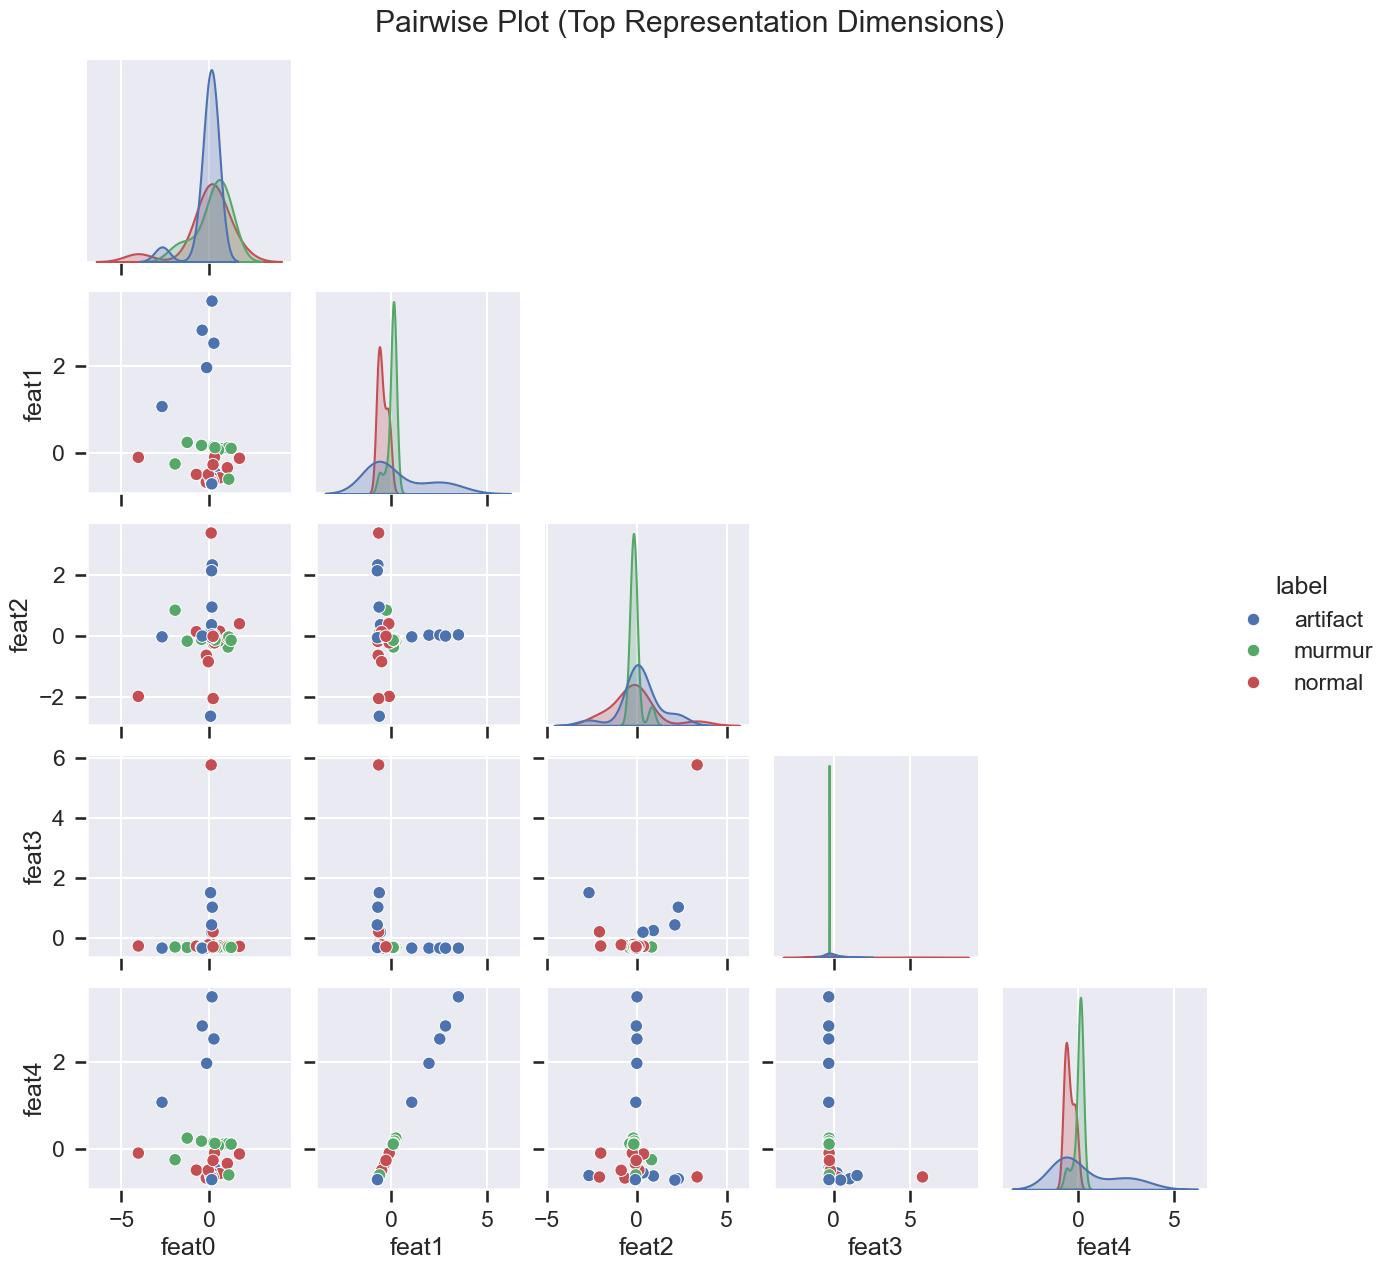

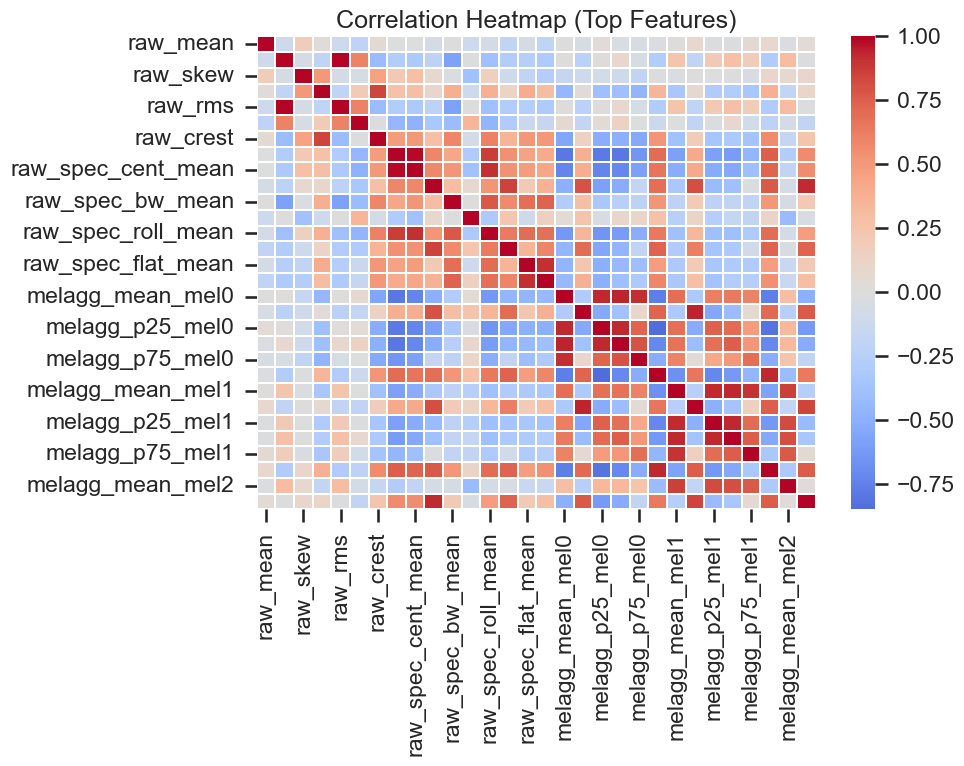

Saved CV results to ..\data\features\revamped_cv_results.json
Selected feature/component names sample: ['raw_mean', 'raw_std', 'raw_skew', 'raw_kurt', 'raw_rms', 'raw_peak', 'raw_crest', 'raw_zcr', 'raw_spec_cent_mean', 'raw_spec_cent_std', 'raw_spec_bw_mean', 'raw_spec_bw_std', 'raw_spec_roll_mean', 'raw_spec_roll_std', 'raw_spec_flat_mean']


In [7]:
# 5. Select Best Strategy & Evaluate on Test
cv_df = (pd.DataFrame(cv_results).T
         .sort_values('cv_f1_mean', ascending=False))
print(cv_df)

best_name = cv_df.index[0]
print('Best strategy by CV macro F1:', best_name)

best_pipeline = strategies[best_name]()
best_pipeline.fit(X_train_full, train_y)

# Obtain transformed train features for visualization if transformer present
if 'selector' in best_pipeline.named_steps:
    sel_indices = best_pipeline.named_steps['selector'].selected_indices_
    selected_feature_names = [feature_columns[i] for i in sel_indices]
elif 'pca' in best_pipeline.named_steps:
    selected_feature_names = [f'PC{i}' for i in range(best_pipeline.named_steps['pca'].n_components_)]
else:
    selected_feature_names = feature_columns

# Test evaluation
from sklearn.metrics import classification_report
pred_test = best_pipeline.predict(X_test_full)
print('Test Classification Report')
print(classification_report(test_y, pred_test, target_names=list(forward_map.keys()), zero_division=0))

# 6. Visualization of Selected Features / Components
import matplotlib.pyplot as plt
import seaborn as sns

# If PCA, plot variance ratio
if 'pca' in best_pipeline.named_steps:
    pca_obj = best_pipeline.named_steps['pca']
    plt.figure(figsize=(6,3))
    plt.bar(range(1, pca_obj.n_components_+1), pca_obj.explained_variance_ratio_)
    plt.xlabel('PC'); plt.ylabel('Variance Ratio'); plt.title('PCA Variance Ratio (Selected Components)')
    plt.tight_layout(); plt.show()

# Extract scaled features (before classifier) for pairplot subset
from sklearn.preprocessing import StandardScaler

def get_intermediate_features(pipe: Pipeline, X: np.ndarray) -> np.ndarray:
    """Return feature representation right before classifier for analysis."""
    X_curr = X
    for name, step in pipe.named_steps.items():
        if name == 'clf':
            break
        X_curr = step.transform(X_curr) if hasattr(step, 'transform') else X_curr
    return X_curr

X_repr = get_intermediate_features(best_pipeline, X_train_full)

# Choose up to 5 dimensions for pairplot (either real features or PCs)
plot_dims = min(5, X_repr.shape[1])
plot_df = pd.DataFrame(X_repr[:, :plot_dims], columns=[f'feat{i}' for i in range(plot_dims)])
plot_df['label'] = [backward_map[i] for i in train_y]

sns.pairplot(plot_df, hue='label', diag_kind='kde', corner=True)
plt.suptitle('Pairwise Plot (Top Representation Dimensions)', y=1.02)
plt.show()

# Correlation heatmap of a subset of original features (top 30 by MI if available)
if 'selector' in best_pipeline.named_steps and 'mi_' in dir(best_pipeline.named_steps['selector']):
    mi_vals = best_pipeline.named_steps['selector'].mi_
    mi_series_full = pd.Series(mi_vals, index=feature_columns)
    top_feats_for_corr = mi_series_full.sort_values(ascending=False).head(30).index.tolist()
else:
    # fallback: first 30 features
    top_feats_for_corr = feature_columns[:30]

corr_mat = pd.DataFrame(X_train_full, columns=feature_columns)[top_feats_for_corr].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_mat, cmap='coolwarm', center=0, linewidths=0.2)
plt.title('Correlation Heatmap (Top Features)')
plt.tight_layout(); plt.show()

# 7. Persist Artifacts (optional)
import json
RESULTS_OUT = FEATURE_DIR / 'revamped_cv_results.json'
cv_export = cv_df.to_dict(orient='index')
with open(RESULTS_OUT, 'w') as f:
    json.dump({"cv_results": cv_export, "best_strategy": best_name}, f, indent=2)
print('Saved CV results to', RESULTS_OUT)

print('Selected feature/component names sample:', selected_feature_names[:15])